In [1]:
import numpy as np
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
style.use('ggplot')

In [2]:
### Initial setup
SIZE = 20 # n by n grid
HM_EPISODES = 140000
STEPS = 100 # SIZE*4
SHOW_EVERY = 20000




### Initial states
c_x = 0 # x-coordinate for the charging station
c_y = 0 # y-coordinate for the charging station
survivor_x = SIZE - 2 # x-coordinate for survivor group (subject to change between survivors)
survivor_y = SIZE - 1 # y-coordinate for survivor group (subject to change between survivors)
b = STEPS # Initial battery level


### Rewards / penalties
move_penalty = 5 # Move penalty
ch_station_reward = 200 # Reward for when the drone goes back to the charging station having had helped a survivor
battery_penalty = -300 # Penalty for when the drone goes out of battery


### Hyperparameters
epsilon = 0.9
EPS_DECAY = 0.99998
LEARNING_RATE = 0.1
DISCOUNT = 0.95


start_q_table = None # or filename



DRONE_N = 1
SURVIVOR_N = 2


d = {1: (255, 175, 0),
     2: (0, 255, 0)}

In [3]:
class Drone:
    def __init__(self):
        
        self.x = c_x # Initial position of drone
        self.y = c_y # Initial position of drone
        self.done = 0
        #self.b = b
    
    def __str__(self):
        return f"{self.x}, {self.y}"
    
    def state(self):
        obs = (self.x, self.y, self.done)#, self.b)
        return obs
    
    def action(self, choice, N, other, i, add = False):
        if choice == 0:
            self.move(x=1, y=1)
            #self.b -= 1
      
        elif choice == 1:
            self.move(x=1, y=-1)
            #self.b -= 1
            
        elif choice == 2:
            self.move(x=1, y=0)
            #self.b -= 1
            
        elif choice == 3:
            self.move(x=0, y=1)
            #self.b -= 1
         
        elif choice == 4:
            self.move(x=0, y=-1)
            #self.b -= 1
            
        elif choice == 5:
            self.move(x=-1, y=1)
            #self.b -= 1
          
        elif choice == 6:
            self.move(x=-1, y=0)
            #self.b -= 1
            
        elif choice == 7:
            self.move(x=-1, y=-1)  
            #self.b -= 1


        #self.c = self.charging_point_distance()
    
    def move(self, x=False, y=False):
        if not x:
            self.x += 0#np.random.randint(0, 2)
        else:
            self.x += x
        if not y:
            self.y += 0#np.random.randint(-1, 2)
        else:
            self.y += y
            
        
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE - 1:
            self.x = SIZE - 1
            
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE - 1:
            self.y = SIZE - 1  
    
    # Calculates drone's distance to charging station
    def charging_point_distance(self):
        c = int(np.sqrt(((self.x - c_x)**2 + (self.y - c_y)**2)))
        return c

In [4]:
class Survivor:
    def __init__(self, survivor_x, survivor_y, N):
        
        self.n = N # Number of survivors
        self.x = survivor_x # x-coordinate position of the group of survivors
        self.y = survivor_y # y-coordinate position of the group of survivors
        self.reward = N*10

In [5]:
# Creation of the q_table
# Each index for the q table is the state variable of the system in the form S_t(x, y, done, c)

if start_q_table is None:
    q_table = {}
    for x1 in range(0, SIZE):
        for y1 in range(0, SIZE):
            for done in range(2):
                #for battery_level in range(SIZE*4 + 1):
                q_table[((x1, y1, done))] = [np.random.uniform(-5,0) for i in range(8)]
                        
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f) 

[17, 11, 5, 11]
on # 0, epsilon: 0.9
20000 ep mean nan


C:\Users\Germa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Germa\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Germa\AppData\Local\Temp\ipykernel_22320\2955035862.py:53: DeprecationWarning: This function is deprecated. Please call randint(9, 13 + 1) instead
  real_surv = np.random.random_integers(survivors[j].n - 2, survivors[j].n + 2)
C:\Users\Germa\AppData\Local\Temp\ipykernel_22320\2955035862.py:53: DeprecationWarning: This function is deprecated. Please call randint(3, 7 + 1) instead
  real_surv = np.random.random_integers(survivors[j].n - 2, survivors[j].n + 2)
C:\Users\Germa\AppData\Local\Temp\ipykernel_22320\2955035862.py:53: DeprecationWarning: This function is deprecated. Please call randint(15, 19 + 1) instead
  real_surv = np.random.random_integers(s

on # 20000, epsilon: 0.6032856282523144
20000 ep mean -401.8915
on # 40000, epsilon: 0.4043928325064372
20000 ep mean -129.078
on # 60000, epsilon: 0.27107153779931065
20000 ep mean -20.1065
on # 80000, epsilon: 0.18170395886953242
20000 ep mean 19.172
on # 100000, epsilon: 0.12179931886948847
20000 ep mean 39.031
on # 120000, epsilon: 0.08164419844987193
20000 ep mean 53.3505


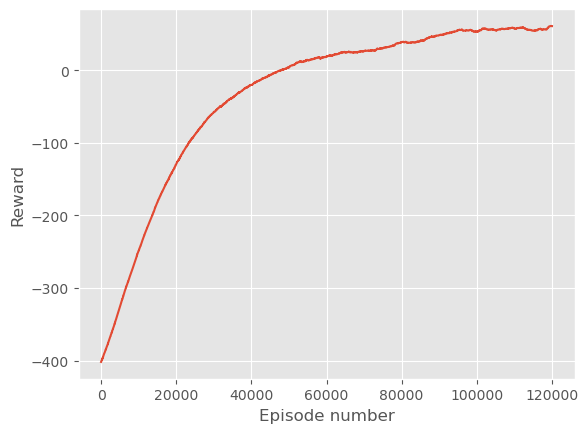

In [6]:
n_surv = random.randint(2, 6)
episode_rewards = []
n_survivors = [random.randint(1, 20) for i in range(n_surv)]
print(n_survivors)

more_surv = 0
less_surv = 0
q_surv = []

for episode in range(HM_EPISODES):
    
    drone = Drone()
    survivors = []
    counter = 0

    for j in range(len(n_survivors)): #random.randint(2,4)*j             survivor_x - 4*j
        survivors.append(Survivor(survivor_x - 4*j, survivor_y - 2*j, n_survivors[j]))
    
    if episode % SHOW_EVERY == 0:
        print(f"on # {episode}, epsilon: {epsilon}")
        print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
        
        
        
        
        
    episode_reward = 0       
    
    for i in range(STEPS):
        
        
        #surv = -100000000000
        obs = drone.state()
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 8)
        
        
        
        drone.action(action, N = 3, other = drone, i = 1)
        
                
### REWARD

        reward = -move_penalty 
        for j in range(len(n_survivors)):
            if drone.x == survivors[j].x and drone.y == survivors[j].y and drone.done == 0:
                drone.done = 1
                real_surv = np.random.random_integers(survivors[j].n - 2, survivors[j].n + 2)
                if real_surv >= survivors[j].n:
                    reward = survivors[j].reward
                    more_surv += 1
                    q_surv.append(real_surv - survivors[j].n)
                elif real_surv < survivors[j].n:
                    reward = -survivors[j].reward
                    less_surv += 1
                    q_surv.append(real_surv - survivors[j].n)
            
                
                
            elif drone.x == survivors[j].x and drone.y == survivors[j].y and drone.done == 1:
                reward = -survivors[j].reward
                
        if drone.x == c_x and drone.y == c_y and drone.done == 1:
            reward = ch_station_reward
        #elif drone.b == 0: 
        #    reward = battery_penalty
            
        
    
### NEW OBS         
            
        new_obs = drone.state()
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
        

### NEW q 
        
        if reward == ch_station_reward:# or reward == battery_penalty: # Termination 
            new_q = reward
        else: # No goal reached
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)             
        
        q_table[obs][action] = new_q

 


        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            env[drone.y][drone.x] = d[DRONE_N]
            for j in range(len(n_survivors)):
                env[survivors[j].y][survivors[j].x] = d[SURVIVOR_N]

                
                
            img = Image.fromarray(env, "RGB")
            img = img.resize((300,300))
            cv2.imshow("", np.array(img))
            
        
                
            # Simulation ended (pause)
            if reward != ch_station_reward:# or reward != battery_penalty:
                if cv2.waitKey(300) & 0xFF == ord("q"):
                    break
            else:
                if cv2.waitKey(200) & 0xFF == ord("q"):
                    break                
        
        episode_reward += reward
        

        
        if reward == ch_station_reward:# or reward == battery_penalty:
            break
            
            
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,)) / SHOW_EVERY, mode = "valid")
            
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel("Reward")
plt.xlabel("Episode number")
plt.show()



#with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
#    pickle.dump(q_table, f)               

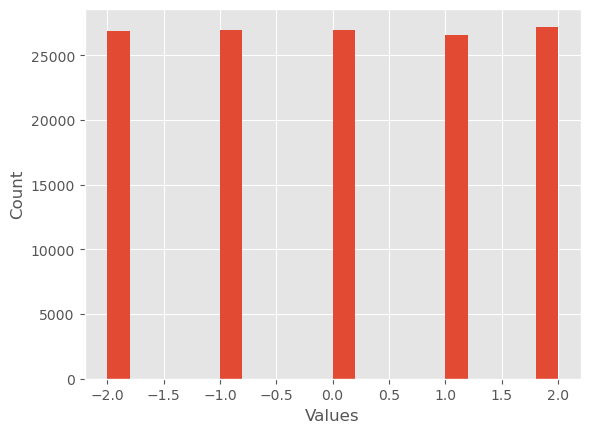

In [7]:
data = q_surv
# create a histogram with 20 bins
plt.hist(data, bins=20)

# set the x-axis label
plt.xlabel('Values')

# set the y-axis label
plt.ylabel('Count')

# show the plot
plt.show()
